Heavily leveraging example given here https://docs.seldon.io/projects/alibi-detect/en/latest/examples/cd_online_wine.html

In [1]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

In [2]:
wine_data = load_wine()
feature_names = wine_data.feature_names

X, y = wine_data.data, wine_data.target
X_ref, X_test, y_ref, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [3]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
import numpy as np
import scipy

# Drift Detection
## Data Drift
### Feature drift

In [12]:
from alibi_detect.cd import TabularDrift

In [15]:
cd = TabularDrift(X_ref, p_val=0.05)

/home/mleroch/miniconda3/envs/mlewp-chapter03/lib/python3.10/site-packages/alibi_detect/cd/tabular.py:113: UserWarning: No `categories_per_feature` dict provided so all features are assumed to be numerical. `KSDrift` will be applied to all features.
  warnings.warn('No `categories_per_feature` dict provided so all features are assumed to be numerical. '


In [16]:
preds = cd.predict(X_test)
labels = ['No', 'Yes']
print('Drift: {}'.format(labels[preds['data']['is_drift']]))

Drift: No


In [17]:
X_test_cal_error = 1.1*X_test
preds = cd.predict(X_test_cal_error)
labels = ['No', 'Yes']
print('Drift: {}'.format(labels[preds['data']['is_drift']]))

Drift: Yes


### Label drift

In [18]:
cd = TabularDrift(y_ref, p_val=0.05)

/home/mleroch/miniconda3/envs/mlewp-chapter03/lib/python3.10/site-packages/alibi_detect/cd/tabular.py:113: UserWarning: No `categories_per_feature` dict provided so all features are assumed to be numerical. `KSDrift` will be applied to all features.
  warnings.warn('No `categories_per_feature` dict provided so all features are assumed to be numerical. '


In [20]:
preds = cd.predict(y_test)
labels = ['No', 'Yes']
print('Drift: {}'.format(labels[preds['data']['is_drift']]))

Drift: No


In [21]:
y_test_cal_error = 1.1*y_test
preds = cd.predict(y_test_cal_error)
labels = ['No', 'Yes']
print('Drift: {}'.format(labels[preds['data']['is_drift']]))

Drift: Yes


## Concept Drift

In [4]:
from alibi_detect.cd import MMDDriftOnline

/home/mleroch/miniconda3/envs/mlewp-chapter03/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
ert = 50
window_size = 10
cd = MMDDriftOnline(X_ref, ert, window_size, backend='pytorch', n_bootstraps=2500)

No GPU detected, fall back on CPU.


Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████| 10/10 [00:01<00:00,  5.25it/s]


In [26]:
n = X.shape[0]
perm = np.random.permutation(n)
t = 0
# cd.reset()
# while True:
#     pred = cd.predict(X[perm[t%n]])
#     if pred['data']['is_drift'] == 1:
#         return t
#     else:
#         t += 1

In [27]:
import pandas as pd

In [28]:
df_X_ref = pd.DataFrame(X_ref)

In [29]:
df_X_test = pd.DataFrame(X_test)

<Axes: >

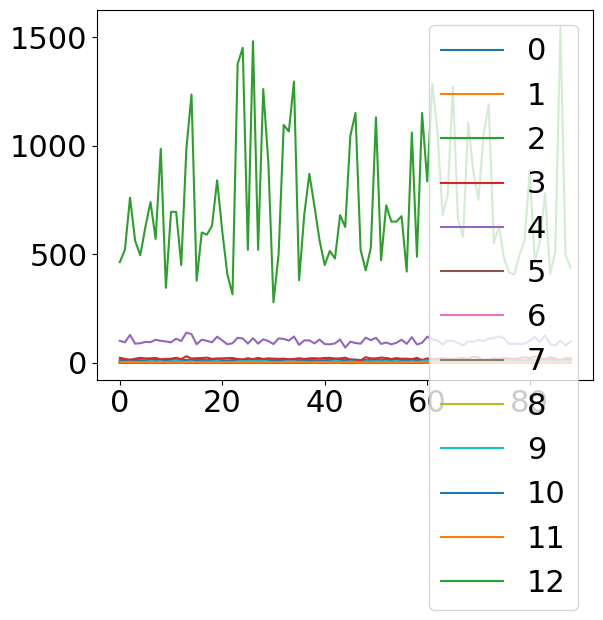

In [30]:
df_X_ref.plot()

<Axes: >

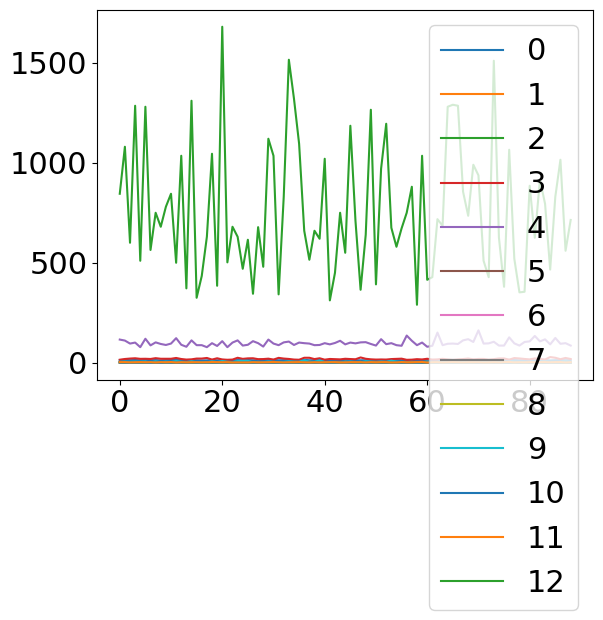

In [31]:
df_X_test.plot()

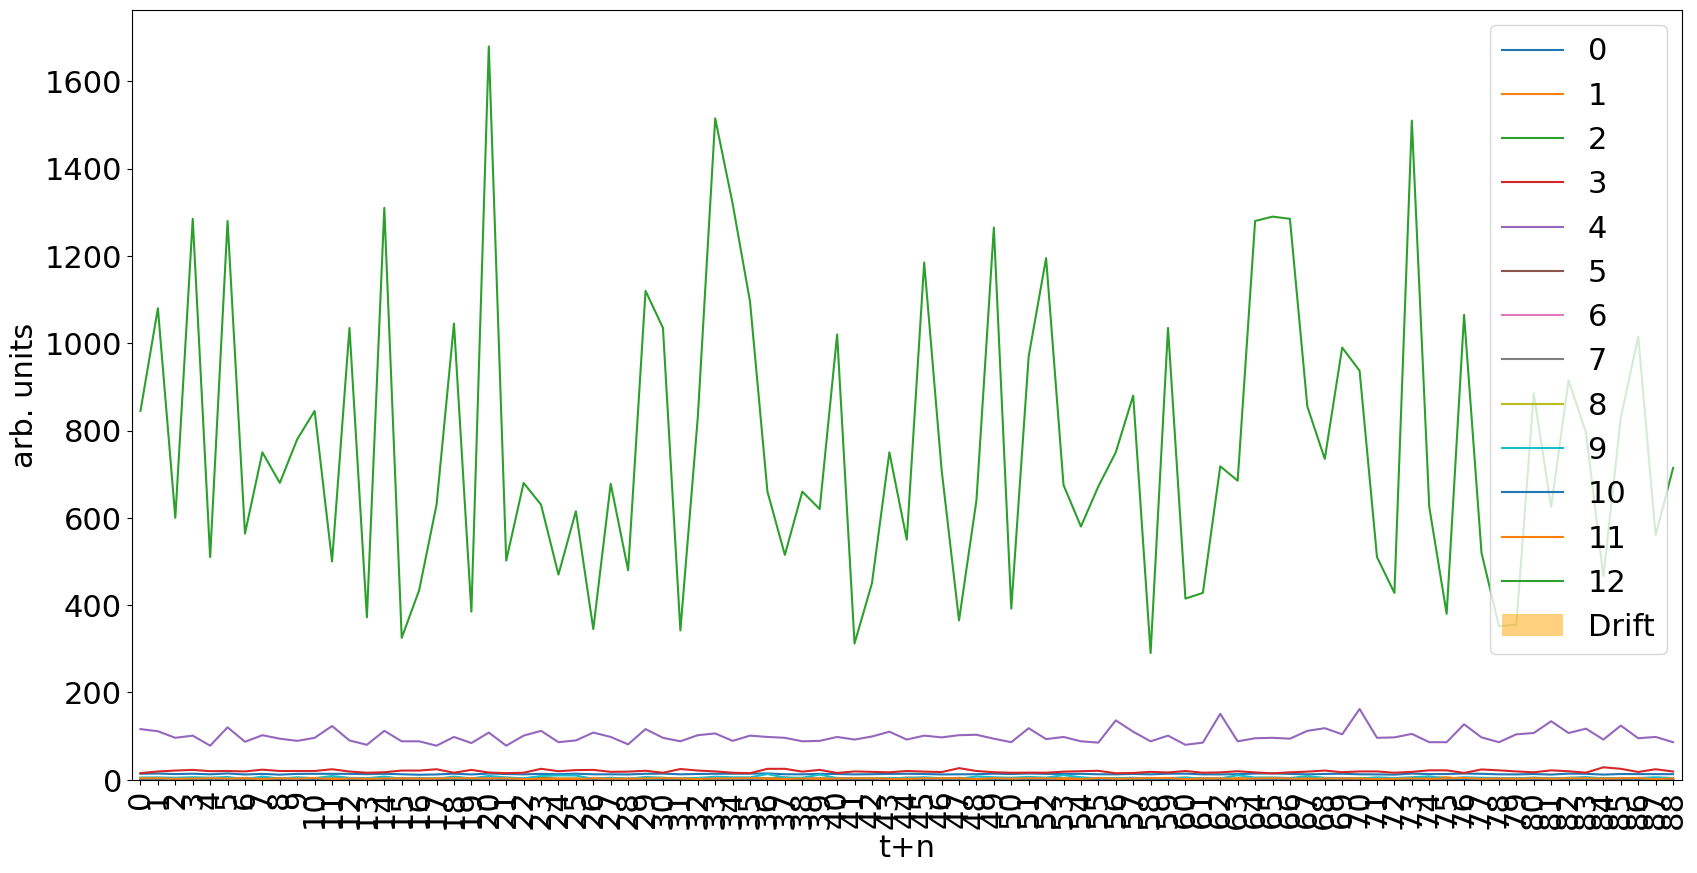

In [32]:
fig, ax = plt.subplots(figsize=(20,10))
df_X_test.plot(ax=ax, label='_nolegend_')
df_X_test.apply(lambda x: 1750*cd.predict(x.values)['data']['is_drift'], axis=1).plot(kind='bar', ax=ax, color='orange', alpha=0.5, label='Drift')
ax.set_xlabel('t+n')
ax.set_ylabel('arb. units')
ax.legend(loc='upper right', shadow=True)
plt.legend()

/home/mleroch/miniconda3/envs/mlewp-chapter03/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:807: UserWarning: The label '_0' of <matplotlib.lines.Line2D object at 0x7fda4d977280> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)
/home/mleroch/miniconda3/envs/mlewp-chapter03/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:807: UserWarning: The label '_1' of <matplotlib.lines.Line2D object at 0x7fda4d9775b0> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)
/home/mleroch/miniconda3/envs/mlewp-chapter03/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:807: UserWarning: The label '_2' of <matplotlib.lines.Line2D object at 0x7fda4d977940> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)
/home/mleroch/miniconda3/envs/mlewp-chapter03/lib/python3.10/site-packages/pandas/

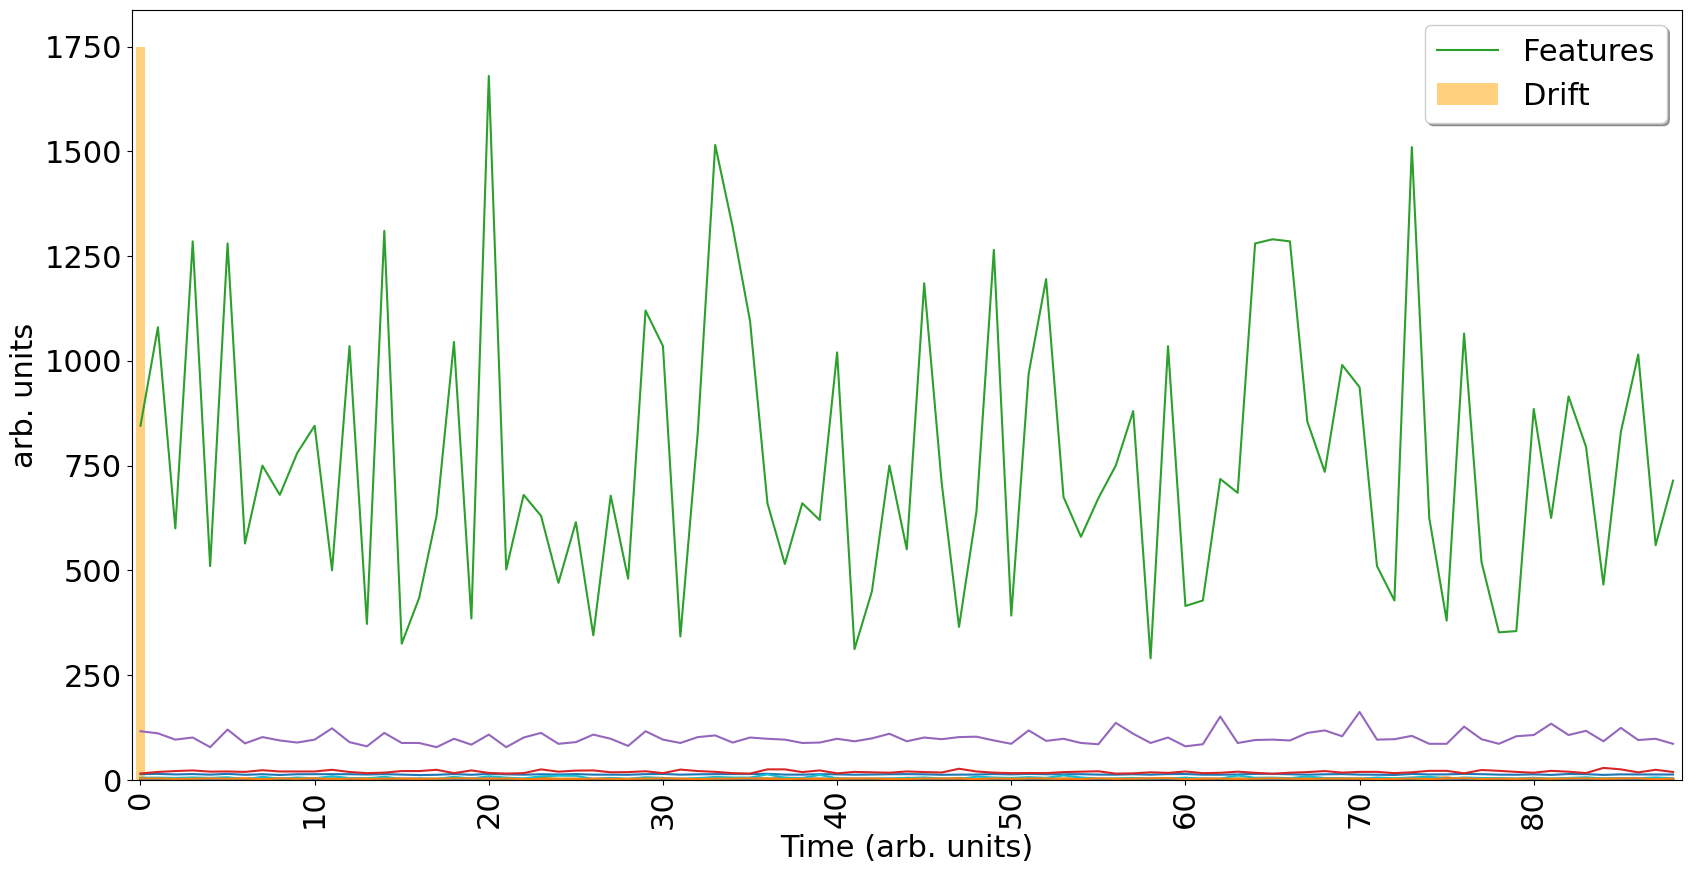

In [33]:
#### SIMULATE DRIFT DETECTION AND PLOT - USE A LAMBDA
fig, ax = plt.subplots(figsize=(20,10))

cols = ["_" + str(col) for col in df_X_test.columns]
cols[-1] = 'Features'
df_X_test.columns = cols

df_X_test.plot(ax=ax)
ax.set_xlabel('Time (arb. units)')
ax.set_ylabel('arb. units')

ax2= df_X_test.apply(lambda x: 1750*cd.predict(x.values)['data']['is_drift'], axis=1).plot(
    kind='bar', 
    ax=ax,
    color='orange', 
    alpha=0.5, 
    label='Drift')

ax2.legend(loc='upper right', shadow=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(9))

# Drift Diagnosis
## Model-based feature importance

In [62]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=3,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    random_state=0,
    shuffle=False,
)
feature_names = [f"feature {i}" for i in range(X.shape[1])]
X = pd.DataFrame(X,columns=feature_names)
y = pd.DataFrame(y) 


In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [64]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(random_state=0)

In [65]:
importances = rf.feature_importances_
std = np.std([rf.feature_importances_ for tree in rf.estimators_], axis=0)

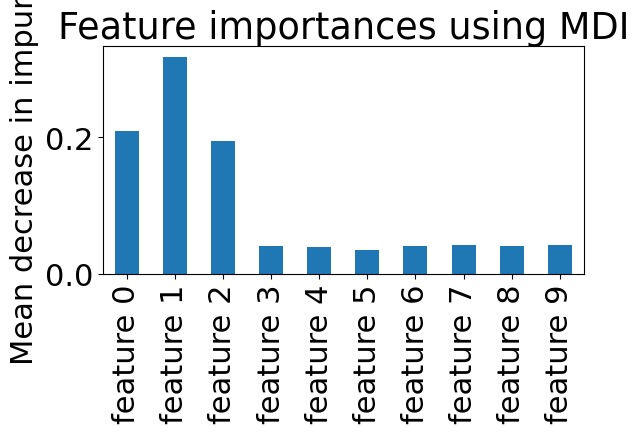

In [66]:
import pandas as pd

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Model-free feature importance
### Permutations

In [67]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

importances = pd.Series(result.importances_mean,index=feature_names)

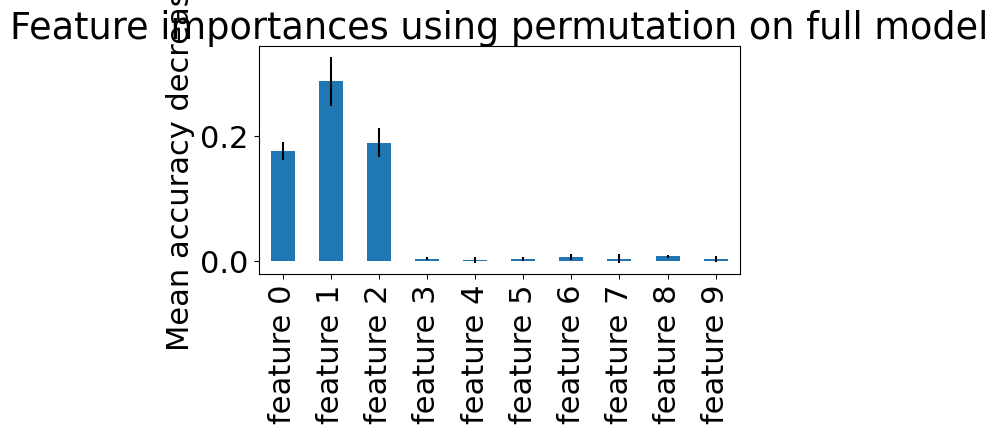

In [68]:
fig, ax = plt.subplots()
importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### Shap

In [69]:
import shap

In [70]:
explainer = shap.Explainer(rf, X_test)
shap_values = explainer(X_test)

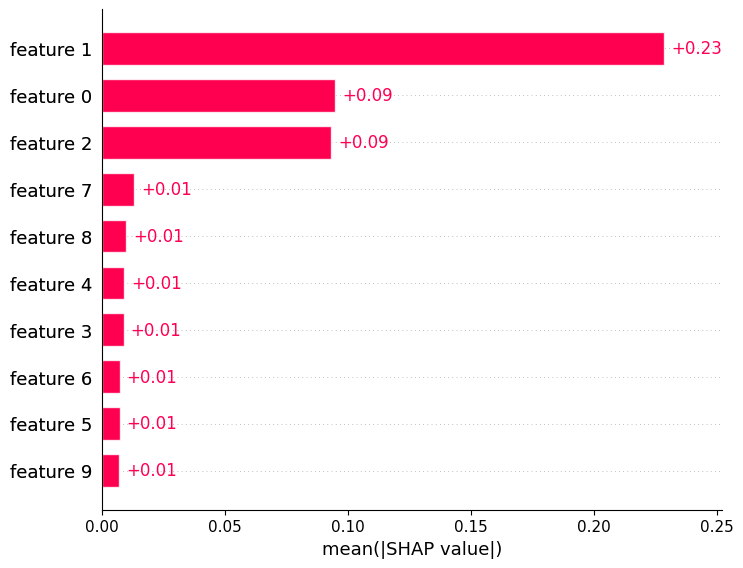

In [72]:
shap.plots.bar(shap_values[:,:,1])